First, import the necessary packages. The neural network will be built in tensorflow using keras as a wrapper.

In [1]:
# For importing and visualizing data
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# For the neural network
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Print the tensorflow version
print('Tensorflow version: ' + tf.__version__)

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Tensorflow version: 1.12.0


Now download snapshots of the Kuramoto-Sivashinksy equation. We will use the neural network to predict the next time step from the current time step.

In [2]:
# Download data
import scipy.io
KS = scipy.io.loadmat('L2210000TimeUnits.mat')
KS_traj = KS['ut']

# Convert to numpy array
KS_traj=np.asarray(KS_traj)

# Modify data to remove transient data
[Ntemp,Mtemp]=KS_traj.shape
[N,M]=[Ntemp-1,Mtemp-200]
ut=KS_traj[0:N,200:Mtemp-1]
utt=KS_traj[0:N,201:Mtemp]

print('Input shape: ' + str(ut.shape))
print('Output shape: ' + str(utt.shape))

/anaconda3/lib/python3.6/site-packages/scipy/io/matlab/mio.py:142: MatReadWarning: Duplicate variable name "None" in stream - replacing previous with new
Consider mio5.varmats_from_mat to split file into single variable files
  matfile_dict = MR.get_variables(variable_names)


Input shape: (64, 39800)
Output shape: (64, 39800)


Plot some of the data to verify snapshots were input correctly.

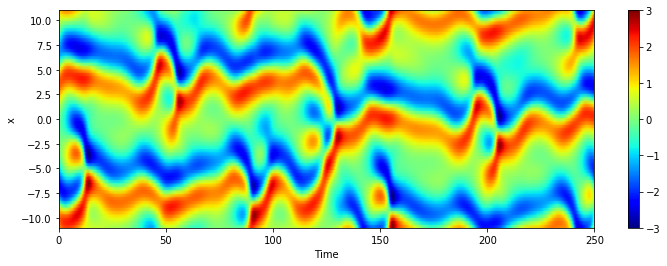

In [3]:
# Plot a portion of the data 
reduced=1000
plt.figure()
fig = plt.gcf()
fig.set_size_inches(12, 4)
plt.pcolormesh(np.linspace(0,reduced/4,reduced), np.linspace(-11,11,N), ut[:,0:reduced], shading='gouraud', cmap=plt.cm.jet,vmin=-3,vmax=3)
plt.xlabel('Time')
plt.ylabel('x')
plt.colorbar()

Split the data randomly into a training and a testing data set (80/20). The matrices are transposed for the shuffling and need to be input this way into the neural network.

In [4]:
# Append data so inputs and outputs are shuffled together
ut=ut.transpose()
utt=utt.transpose()
temp=np.append(ut,utt,axis=1)

# Separate inputs and outputs and training and test data
frac=.8
np.random.shuffle(temp)
ut_train=temp[:round(M*frac),:N]
utt_train=temp[:round(M*frac),N:2*N]
ut_test=temp[round(M*frac):M,:N]
utt_test=temp[round(M*frac):M,N:2*N]

print('Training Shapes')
print('Input shape: ' + str(ut_train.shape))
print('Output shape: ' + str(utt_train.shape))
print('Testing Shapes')
print('Input shape: ' + str(ut_test.shape))
print('Output shape: ' + str(utt_test.shape))


Training Shapes
Input shape: (31841, 64)
Output shape: (31841, 64)
Testing Shapes
Input shape: (7959, 64)
Output shape: (7959, 64)


In this case all inputs and outputs have the same magnitude and distribution. If this were not the case, these values would have needed to be normalized before moving forward. Now that the data is ready, the next step is creating the neural network.

In [5]:
# Build the neural network
model=keras.Sequential()
model.add(layers.Dense(round(N*.75), activation=tf.nn.relu, input_shape=[N]))
model.add(layers.Dense(round(N*.75), activation=tf.nn.relu))
model.add(layers.Dense(N))

# Select and optimization algorithm (This is the method for calculating the weights)
optimizer = tf.train.RMSPropOptimizer(0.001)

# Compile the model (The loss function here is the mean squared error)
model.compile(loss='mse',
            optimizer=optimizer,
            metrics=['mae', 'mse'])

print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 48)                3120      
_________________________________________________________________
dense_1 (Dense)              (None, 48)                2352      
_________________________________________________________________
dense_2 (Dense)              (None, 64)                3136      
Total params: 8,608
Trainable params: 8,608
Non-trainable params: 0
_________________________________________________________________
None


This code generates a fully connected network with 2 hidden layers. I selected the number of nodes to go 64->48->48->64. The Param # corresponds to the total number of weights immediately before that layer and the number of nodes at that layer.

The neural network is complete. All that is left is to input the training data generated above.

In [6]:
# For seeing progress
from printProgressBar import printProgressBar
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    printProgressBar(epoch,EPOCHS)

# Train the model
EPOCHS = 100

history = model.fit(
  ut_train, utt_train,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[PrintDot()])

# View history
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mean_absolute_error,mean_squared_error,val_loss,val_mean_absolute_error,val_mean_squared_error,epoch
95,0.002071,0.035270,0.002071,0.003264,0.045213,0.003264,95
96,0.002060,0.034993,0.002060,0.001981,0.035221,0.001981,96
97,0.002062,0.035090,0.002062,0.001624,0.031438,0.001624,97
98,0.002038,0.034877,0.002038,0.002475,0.038769,0.002475,98
99,0.002023,0.034702,0.002023,0.001100,0.025858,0.001100,99


Looking at the final few epochs we see marginal improvement in the mean squared error. Instead, let's look at the history of the training data.

(0, 0.02)

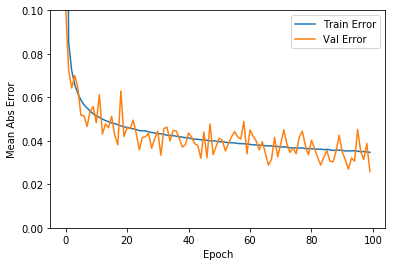

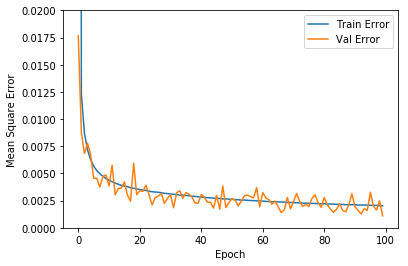

In [7]:
# Plot the mean absolute error
plt.figure()
plt.xlabel('Epoch')
plt.ylabel('Mean Abs Error')
plt.plot(hist['epoch'], hist['mean_absolute_error'],label='Train Error')
plt.plot(hist['epoch'], hist['val_mean_absolute_error'],label = 'Val Error')
plt.legend()
plt.ylim([0,.1])

# Plot the mean square error
plt.figure()
plt.xlabel('Epoch')
plt.ylabel('Mean Square Error')
plt.plot(hist['epoch'], hist['mean_squared_error'],
       label='Train Error')
plt.plot(hist['epoch'], hist['val_mean_squared_error'],
       label = 'Val Error')
plt.legend()
plt.ylim([0,.02])

From these figures it is clear that it only took a few epochs for the error to become small. The true test, however, is how well the model predicts the test data.

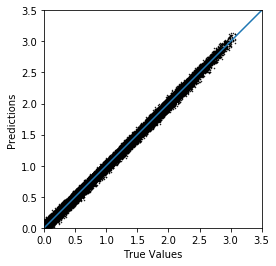

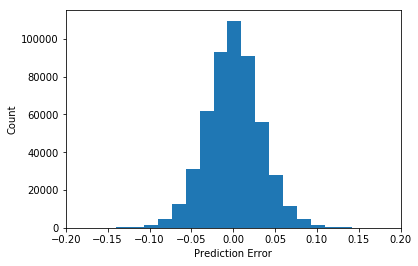

In [8]:
# Prediction
test_predictions = model.predict(ut_test).flatten()

# Plot of flattened data
plt.figure()
plt.plot(utt_test.flatten(), test_predictions,'o',color='black',markersize=.5)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,3.5])
plt.ylim([0,3.5])
_ = plt.plot([-100, 100], [-100, 100])

# Histogram of error
error = test_predictions - utt_test.flatten()
plt.figure()
plt.hist(error, bins = 25)
plt.xlim([-.2,.2])
plt.xlabel("Prediction Error")
_ = plt.ylabel("Count")

To see how well this actually performs let's compare to DMD, a linear method.

In [9]:
# Compare to DMD

#Rearrange data
from sklearn.utils.extmath import randomized_svd
utDMD_train=ut_train.transpose()
uttDMD_train=utt_train.transpose()
utDMD_test=ut_test.transpose()
uttDMD_test=utt_test.transpose()

# Perform SVD on the training data
U,S,VT=randomized_svd(utDMD_train, n_components=N)
S_inv=1./S
S_r_inv=np.diag(S_inv)

# Linear prediction operator
L=uttDMD_train @ np.transpose(VT) @ S_r_inv @ np.transpose(U)

# Predict on test data 
linear_prediction = L @ utDMD_test

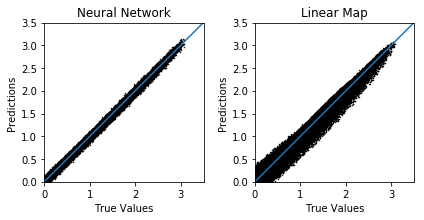

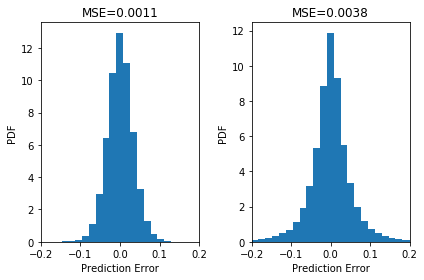

In [10]:
# Plot side by side for comparison
# Plot prediction
plt.figure()
plt.subplot(1, 2, 1)
plt.plot(utt_test.flatten(), test_predictions,'o',color='black',markersize=.5)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.axis('equal')
plt.axis('square')
plt.title('Neural Network')
plt.xlim([0,3.5])
plt.ylim([0,3.5])
_ = plt.plot([-100, 100], [-100, 100])
plt.subplot(1, 2, 2)
plt.plot(uttDMD_test.flatten(), linear_prediction.flatten(),'o',color='black',markersize=.5)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.axis('equal')
plt.axis('square')
plt.title('Linear Map')
plt.xlim([0,3.5])
plt.ylim([0,3.5])
_ = plt.plot([-100, 100], [-100, 100])
plt.tight_layout()

# Plot histograms
boxes=np.linspace(-.2,.2+.4/25,25)
plt.figure()
plt.subplot(1,2,1)
error = test_predictions - utt_test.flatten()
plt.hist(error, bins = boxes,density=True)
plt.xlim([-.2,.2])
plt.xlabel("Prediction Error")
plt.title('MSE='+str(round(np.mean(error**2),4)))
_ = plt.ylabel("PDF")
plt.subplot(1,2,2)
error = linear_prediction.flatten() - uttDMD_test.flatten()
plt.hist(error, bins = boxes,density=True)
plt.xlim([-.2,.2])
plt.xlabel("Prediction Error")
plt.title('MSE='+str(round(np.mean(error**2),4)))
_ = plt.ylabel("PDF")
plt.tight_layout()

The neural network does slightly better than the linear method for a single timestep. How does it perform for multiple timesteps?

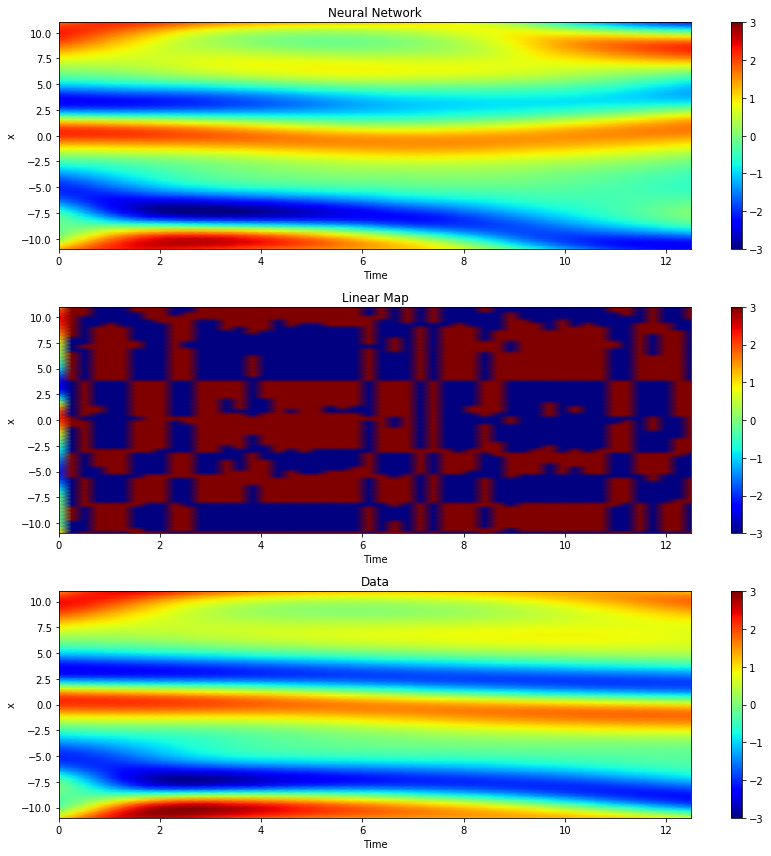

In [12]:
# Plot a time series of the Neural Network
# Number of steps
reduced=50
# Starting snapshot
start=1000
ut_predictNN=np.zeros((N,reduced))
ut_predictDMD=np.zeros((N,reduced))

# Loop through timesteps
for t in range(reduced):
    if t==0:
        ut_predictNN[:,t] = np.squeeze(model.predict(ut[start:start+1,:]).transpose())
        ut_predictDMD[:,t] = np.squeeze(L @ ut[start:start+1,:].transpose())
    else:
        ut_predictNN[:,t] = np.squeeze(model.predict(ut_predictNN[:,t-1:t].transpose()).transpose())
        ut_predictDMD[:,t] = np.squeeze(L @ ut_predictDMD[:,t-1:t])

# Plot the time series 
plt.figure()
plt.subplot(3,1,1)
fig = plt.gcf()
plt.pcolormesh(np.linspace(0,reduced/4,reduced), np.linspace(-11,11,N), ut_predictNN[:,0:reduced], shading='gouraud', cmap=plt.cm.jet,vmin=-3,vmax=3)
plt.xlabel('Time')
plt.ylabel('x')
plt.title('Neural Network')
plt.colorbar()
plt.subplot(3,1,2)
fig = plt.gcf()
plt.pcolormesh(np.linspace(0,reduced/4,reduced), np.linspace(-11,11,N), ut_predictDMD[:,0:reduced], shading='gouraud', cmap=plt.cm.jet,vmin=-3,vmax=3)
plt.xlabel('Time')
plt.ylabel('x')
plt.title('Linear Map')
plt.colorbar()
plt.subplot(3,1,3)
fig = plt.gcf()
plt.pcolormesh(np.linspace(0,reduced/4,reduced), np.linspace(-11,11,N), ut[start:start+reduced,:].transpose(), shading='gouraud', cmap=plt.cm.jet,vmin=-3,vmax=3)
plt.xlabel('Time')
plt.ylabel('x')
plt.title('Data')
plt.colorbar()
fig.set_size_inches(12, 12)
plt.tight_layout()

The neural network does a decent job of recreating the data over this short timespan, while the linear map blows up.